In [3]:
from vikingzero.agents.alphago import CnnNNetSmall
from vikingzero.environments.tictactoe_env import TicTacToe
from vikingzero.search import ZeroMCTS, ZeroNode

import numpy as np
import pydot
import torch
from IPython.display import Image, display


from torch.autograd import Variable

In [4]:
tictactoe = TicTacToe()

env = tictactoe

player = env.check_turn(env.board)

winner = env.check_winner(env.board)

root = ZeroNode(state=env.board, player=player, winner=winner, parent=None, parent_action=None)

In [5]:
def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)


In [6]:
def _repr_png_(mcts):
    g = pydot.Dot(graph_type="digraph")

    num_points = mcts.points
    for i in range(num_points):
        node = mcts.dec_pts[i]
        if node.terminal():

            node_label = f" Leaf: Winner = {node.winner} "
        else:
            node_label = " Player: " + str(mcts.dec_pts[i].player)

        g.add_node(pydot.Node('node%d' % i, label=node_label))

    for i in range(num_points):

        parent = mcts.dec_pts[i]
        for child in mcts.children[i]:

            c_index = mcts.dec_pts.index(child)
            Qsa = mcts._Qsa[(parent,child.parent_action)]
            Nsa = mcts._Nsa[(parent,child.parent_action)]
            edge_label = f"action={child.parent_action} \n"
            edge_label += f"Qsa = {Qsa} \n"
            edge_label += f"Nsa = {Nsa}"

            edge = pydot.Edge('node%d' % i, 'node%d' % c_index,label=edge_label)
            g.add_edge(edge)

    write_path = 'tree.png'
    #g.write(write_path, format="png")

    return g


def state_encoder(node):
    board = node.state
    board = board.reshape((3, 3))
    p1 = np.zeros(board.shape)
    p2 = np.zeros(board.shape)
    p = np.ones(board.shape)

    p1[board == 1] = 1
    p2[board == 2] = 1
    turn = env.check_turn(board)
    p = p if turn == 1 else p * -1
    board = np.stack((p1, p2, p))

    board = Variable(torch.from_numpy(board).type(dtype=torch.float))

    return board

In [7]:
nn = CnnNNetSmall(3, 3, 9, 32, 0.3)


zero_mcts = ZeroMCTS(env,nn,state_encoder,c=1.41,dir_noise=0.3,dir_eps=0.2)

zero_mcts.children.append([])
zero_mcts.dec_pts.append(root)
zero_mcts.parents.append(None)
zero_mcts.root = root


for _ in range(25):
    zero_mcts.run(root)

In [8]:
g = _repr_png_(zero_mcts)

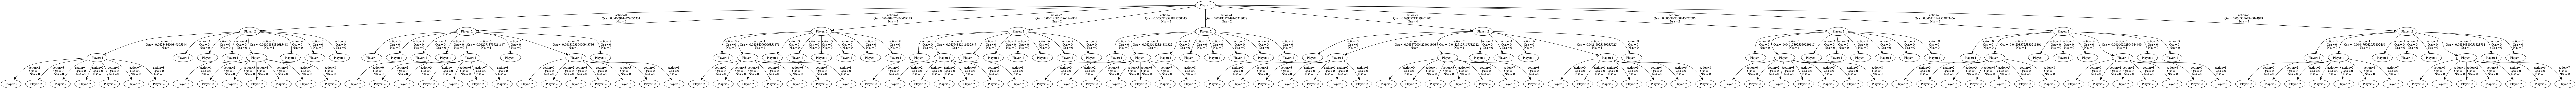

In [9]:
view_pydot(g)

In [10]:
a, p = zero_mcts.policy(root,1, max=False)

In [11]:
a

0

In [12]:
p

array([0.125     , 0.125     , 0.08333333, 0.08333333, 0.08333333,
       0.16666667, 0.08333333, 0.125     , 0.125     ])

In [13]:
print(root)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [14]:
p.sum()

1.0

In [15]:
def get_qa(mcts,node,p_nn):
    
    valid_actions = env.valid_actions(node.state)

    qa = [mcts._Qsa[(node,a)] for a in valid_actions]
    
    p_nn[[a for a in range(9) if a not in valid_actions ]] = 0
    
    p_nn /= p_nn.sum()
    
    return np.array(qa), p_nn

In [16]:
def compute_multiplier(mcts,node,env) -> float:
    
    valid_actions = env.valid_actions(node.state)
    
    n = 0
    for a in valid_actions:
        n += mcts._Nsa[(node,a)]
        
    return np.sqrt(n) / (n + len(valid_actions))

In [17]:
lambda_n = compute_multiplier(zero_mcts,root,env)

In [18]:
def compute_pi_bar(p_nn,L,q,alpha):
    
    q = np.array(q)
    p_nn = np.array(p_nn)
    return L * p_nn / (alpha - q)

In [19]:
def find_max_min_alpha(p_a,L,q):
    
    a = q + L*p_a
    
    min_alpha = np.max(a)
    
    b = q + L
    
    max_alpha = np.max(b)
    
    return min_alpha, max_alpha

In [20]:
def find_max_alpha(node,env,mcts,p_nn):
    
    l_n = compute_multiplier(mcts,node,env)
    
    q,p_nn = get_qa(mcts,node,p_nn)
    
    min_a, max_a = find_max_min_alpha(p_nn,l_n,q)
    
    
    alpha_star = min_a
    
    delta = 10000
    pi_bar = None
    half = None
    
    epsilon = 0.00000001
    
    while True:
        
        half = (min_a + max_a) / 2.0
        
        pi_bar = compute_pi_bar(p_nn,l_n,q,half)
        
        if pi_bar.sum() > (1 + epsilon):
            
            min_a = half
            
        elif pi_bar.sum() < (1 - epsilon):
            
            max_a = half
            
        else:
            print("Found max alpha! ")
            print(half)
            return half , pi_bar
        
        
        
        

In [23]:
max_a, pi_bar = find_max_alpha(root,env,zero_mcts,p_nn)

Found max alpha! 
0.1877776060894139


In [24]:
print(pi_bar.sum())

1.0000000007251009


In [175]:
pi_bar = compute_pi_bar(p_nn,lambda_n,qa,0.1)

In [188]:
pi_bar.sum()

0.9435704782857957

In [154]:
p_nn.sum()

1.0

In [139]:
lambda_a

0.14845392380504108

In [140]:
2 + 2

4

In [22]:
p_nn = np.random.random((9,))

In [114]:
qa , p_nn = get_qa(zero_mcts,root,p_nn)

In [115]:
qa

array([ 0.00360695,  0.00194198,  0.00150316, -0.08182791, -0.09138964,
        0.00224549, -0.18113634, -0.08829121, -0.08572339])

In [116]:
p_nn

array([0.17895723, 0.07412042, 0.07617748, 0.19638942, 0.04142135,
       0.12754713, 0.07401875, 0.06614968, 0.16521855])

In [145]:
min_a, max_a = find_max_min_alpha(p_nn,lambda_a,qa)

In [146]:
min_a

0.030173855014211402

In [147]:
max_a

0.15206087653188205

In [148]:
(min_a + max_a) / 2.0

0.09111736577304673

In [149]:
pi_bar = compute_pi_bar(p,lambda_a,qa,min_a)

In [150]:
pi_bar.sum()

2.53049100498196